# 第6章: 機械学習
50. データの入手・整形
51. 特徴量抽出
52. 学習
53. 予測
54. 正解率の計測
55. 混同行列の作成
56. 適合率，再現率，F1スコアの計測
57. 特徴量の重みの確認
58. 正則化パラメータの変更
59. ハイパーパラメータの探索

本章では，Fabio Gasparetti氏が公開しているNews Aggregator Data Setを用い，ニュース記事の見出しを「ビジネス」「科学技術」「エンターテイメント」「健康」のカテゴリに分類するタスク（カテゴリ分類）に取り組む．

## 50. データの入手・整形

News Aggregator Data Setをダウンロードし、以下の要領で学習データ（train.txt），検証データ（valid.txt），評価データ（test.txt）を作成せよ．

ダウンロードしたzipファイルを解凍し，readme.txtの説明を読む．
情報源（publisher）が”Reuters”, “Huffington Post”, “Businessweek”, “Contactmusic.com”, “Daily Mail”の事例（記事）のみを抽出する．
抽出された事例をランダムに並び替える．
抽出された事例の80%を学習データ，残りの10%ずつを検証データと評価データに分割し，それぞれtrain.txt，valid.txt，test.txtというファイル名で保存する．ファイルには，１行に１事例を書き出すこととし，カテゴリ名と記事見出しのタブ区切り形式とせよ（このファイルは後に問題70で再利用する）．
学習データと評価データを作成したら，各カテゴリの事例数を確認せよ．

In [7]:
!wget "https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip" 
!unzip "NewsAggregatorDataset.zip"

--2021-08-31 04:13:41--  https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29224203 (28M) [application/x-httpd-php]
Saving to: ‘NewsAggregatorDataset.zip.1’

NewsAggregatorDatas 100%[===================>]  27.87M  26.4MB/s    in 1.1s    

2021-08-31 04:13:42 (26.4 MB/s) - ‘NewsAggregatorDataset.zip.1’ saved [29224203/29224203]

Archive:  NewsAggregatorDataset.zip
replace 2pageSessions.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: 2pageSessions.csv       
replace __MACOSX/._2pageSessions.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: __MACOSX/._2pageSessions.csv  
replace newsCorpora.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: newsCorpora.csv         
replace __MACOSX/._newsCorpora.csv? [y]es, [n]o, 

```
Attribute Information:

FILENAME #1: newsCorpora.csv (102.297.000 bytes)
DESCRIPTION: News pages
FORMAT: ID TITLE URL PUBLISHER CATEGORY STORY HOSTNAME TIMESTAMP

where:
ID Numeric ID
TITLE News title
URL Url
PUBLISHER Publisher name
CATEGORY News category (b = business, t = science and technology, e = entertainment, m = health)
STORY Alphanumeric ID of the cluster that includes news about the same story
HOSTNAME Url hostname
TIMESTAMP Approximate time the news was published, as the number of milliseconds since the epoch 00:00:00 GMT, January 1, 1970


FILENAME #2: 2pageSessions.csv (3.049.986 bytes)
DESCRIPTION: 2-page sessions
FORMAT: STORY HOSTNAME CATEGORY URL

where:
STORY Alphanumeric ID of the cluster that includes news about the same story
HOSTNAME Url hostname
CATEGORY News category (b = business, t = science and technology, e = entertainment, m = health)
URL Two space-delimited urls representing a browsing session
```

In [55]:
import pandas as pd
cols = ["id","title","url","publisher","category","story","hostname","timestamp",]
df = pd.read_csv("newsCorpora.csv", sep='\t', names=cols)
df.head()

,id,title,url,publisher,category,story,hostname,timestamp
0,1,"Fed official says weak data caused by weather,...",http://www.latimes.com/business/money/la-fi-mo...,Los Angeles Times,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,1394470370698
1,2,Fed's Charles Plosser sees high bar for change...,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,Livemint,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.livemint.com,1394470371207
2,3,US open: Stocks fall after Fed official hints ...,http://www.ifamagazine.com/news/us-open-stocks...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371550
3,4,"Fed risks falling 'behind the curve', Charles ...",http://www.ifamagazine.com/news/fed-risks-fall...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371793
4,5,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,http://www.moneynews.com/Economy/federal-reser...,Moneynews,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.moneynews.com,1394470372027


In [56]:
df = df.query('publisher in ["Reuters", "Huffington Post", "Businessweek", "Contactmusic.com", "Daily Mail"]')

seed = 200
df_train = df.sample(frac=0.8,random_state=seed)
df_remain = df.drop(df_train.index)
df_valid = df_remain.sample(frac=0.5,random_state=seed)
df_test = df_remain.drop(df_valid.index)

In [57]:
# それぞれtrain.txt，valid.txt，test.txtというファイル名で保存する．ファイルには，１行に１事例を書き出すこととし，カテゴリ名と記事見出しのタブ区切り形式とせよ
with open("train.txt","w") as f:
    for index, row in df_train.iterrows():
        f.write(row["category"] + "\t" + row["title"] + "\n")

with open("valid.txt","w") as f:
    for index, row in df_valid.iterrows():
        f.write(row["category"] + "\t" + row["title"] + "\n")

with open("test.txt","w") as f:
    for index, row in df_test.iterrows():
        f.write(row["category"] + "\t" + row["title"] + "\n")



In [58]:
print("Train:{}\nValid:{}\nTest:{}".format(len(df_train),len(df_valid),len(df_test)))

Train:10672
Valid:1334
Test:1334



## 51. 特徴量抽出

学習データ，検証データ，評価データから特徴量を抽出し，それぞれtrain.feature.txt，valid.feature.txt，test.feature.txtというファイル名で保存せよ． なお，カテゴリ分類に有用そうな特徴量は各自で自由に設計せよ．記事の見出しを単語列に変換したものが最低限のベースラインとなるであろう．



In [59]:
# TF-IDFがいいらしい
# Text を　ベクトル化する
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_union

# 文の長さをベクトルに与える
class CustomVectorizer(TransformerMixin):
    def __init__(self):
        super().__init__()
        self.scaler = MinMaxScaler()

    def fit(self, raw_documents, y=None):
        lengths = np.zeros((len(raw_documents), 1))
        for doc_id, document in enumerate(raw_documents):
            length = len(document)
            lengths[doc_id, 0] = length
        self.scaler.fit(lengths)
        return self

    def transform(self, raw_documents):
        lengths = np.zeros((len(raw_documents), 1))
        for doc_id, document in enumerate(raw_documents):
            length = len(document)
            lengths[doc_id, 0] = length
        lengths = self.scaler.transform(lengths)
        return lengths

# 特徴量を組み合わせて一つのベクトル結合する
vectorizer = make_union(
  TfidfVectorizer(),
  CustomVectorizer()
)

In [60]:
df_train_valid = pd.concat([df_train,df_valid])
x_train_valid = vectorizer.fit_transform(df_train_valid["title"]).toarray() # train, validでフィット、train,validとtestの分布が同じと仮定？
x_test = vectorizer.transform(df_test["title"]).toarray()
print(vectorizer.transformer_list[0][1].get_feature_names())
print('size of tfidf vector', len(vectorizer.transformer_list[0][1].get_feature_names()))

['00', '05', '07', '08', '09', '0ff', '0ut', '10', '100', '1000', '10000', '100000', '100k', '100th', '101', '103', '104', '106', '107', '108', '10k', '10m', '10million', '10th', '11', '110', '1100', '111', '113', '114', '115', '1150', '116', '117', '118', '11m', '12', '120', '1201178058', '121', '1270', '129', '13', '1300', '131', '1399983366398', '1399983366584', '1399983366926', '1399983367118', '1399983367406', '1399983367691', '1399985294553', '1399985294870', '1399985295162', '1399985295432', '13th', '14', '142136', '148', '148948', '149002', '14lb', '14m', '14th', '15', '150', '1500', '1550', '156000', '15lbs', '15m', '15th', '16', '16000', '16k', '16m', '17', '17000', '172', '175', '17500', '178', '179', '18', '18000', '186f', '19', '1900', '19000', '1914', '1918', '1950s', '1956', '1964', '1978', '1979', '1980s', '1981', '1983', '1987', '1990', '1990s', '1996', '1997', '1999', '19m', '19th', '1bn', '1d', '1m', '1q', '1st', '20', '200', '2000', '20000', '200000', '2001', '2003'

In [64]:
x_cols = vectorizer.transformer_list[0][1].get_feature_names() + ["length"]
x_train = x_train_valid[:len(df_train)]
x_valid = x_train_valid[len(df_train):]

# ベクトルをデータフレームに変換
x_train = pd.DataFrame(x_train, columns=x_cols)
x_valid = pd.DataFrame(x_valid, columns=x_cols)
x_test = pd.DataFrame(x_test, columns=x_cols)

# データの保存（重いのでしない）
#x_train.to_csv('train.features.csv', index=False)
#x_valid.to_csv('valid.features.csv', index=False)
#x_test.to_csv('test.features.csv', index=False)

## 52. 学習

51で構築した学習データを用いて，ロジスティック回帰モデルを学習せよ．



In [65]:
from sklearn.linear_model import LogisticRegression

In [106]:
lg = LogisticRegression(random_state=seed, max_iter=1000, verbose=100)
lg.fit(x_train,df_train["category"])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.9min finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=200, solver='lbfgs', tol=0.0001, verbose=100,
                   warm_start=False)

## 53. 予測

52で学習したロジスティック回帰モデルを用い，与えられた記事見出しからカテゴリとその予測確率を計算するプログラムを実装せよ．



In [107]:
def get_probas(x):
    return [np.max(lg.predict_proba(x), axis=1), lg.predict(x)]

get_probas(x_train)

[array([0.94987387, 0.87020651, 0.91319897, ..., 0.6472321 , 0.60348582,
        0.87017636]), array(['b', 'e', 'b', ..., 'b', 't', 'e'], dtype=object)]

## 54. 正解率の計測

52で学習したロジスティック回帰モデルの正解率を，学習データおよび評価データ上で計測せよ．



In [108]:
from sklearn.metrics import accuracy_score

pred_train = get_probas(x_train)
y_train = df_train["category"]
pred_valid = get_probas(x_valid)
y_valid = df_valid["category"]
pred_test = get_probas(x_test)
y_test = df_test["category"]

print("Train accuracy:{}\nValid accuracy:{}\nTest accuracy:{}".format(accuracy_score(y_train,pred_train[1]),accuracy_score(y_valid,pred_valid[1]),accuracy_score(y_test,pred_test[1])))

Train accuracy:0.9452773613193404
Valid accuracy:0.8808095952023988
Test accuracy:0.9010494752623688


## 55. 混同行列の作成

52で学習したロジスティック回帰モデルの混同行列（confusion matrix）を，学習データおよび評価データ上で作成せよ．



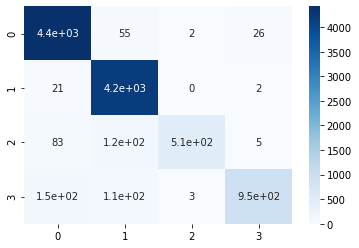

In [109]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

m_train = confusion_matrix(y_train,pred_train[1])
sns.heatmap(m_train, annot=True, cmap='Blues')
plt.show()

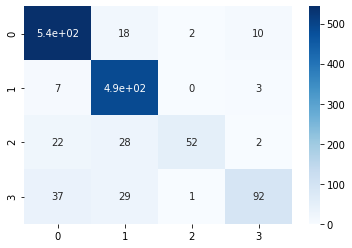

In [110]:
m_valid = confusion_matrix(y_valid,pred_valid[1])
sns.heatmap(m_valid, annot=True, cmap='Blues')
plt.show()

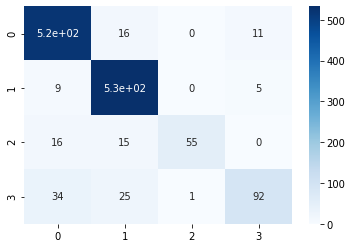

In [111]:
m_test = confusion_matrix(y_test,pred_test[1])
sns.heatmap(m_test, annot=True, cmap='Blues')
plt.show()

## 56. 適合率，再現率，F1スコアの計測

52で学習したロジスティック回帰モデルの適合率，再現率，F1スコアを，評価データ上で計測せよ．カテゴリごとに適合率，再現率，F1スコアを求め，カテゴリごとの性能をマイクロ平均（micro-average）とマクロ平均（macro-average）で統合せよ．



In [112]:
from sklearn.metrics import precision_score, recall_score, f1_score

def integrated_score(y,pred):
    precision = precision_score(y,pred,labels=["b","e","t","m"],average=None)
    precision = np.append(precision,precision_score(y,pred,average="micro"))
    precision = np.append(precision,precision_score(y,pred,average="macro"))

    rc = recall_score(y,pred,labels=["b","e","t","m"],average=None)
    rc = np.append(rc,recall_score(y,pred,average="micro"))
    rc = np.append(rc,recall_score(y,pred,average="macro"))

    f1 = f1_score(y,pred,labels=["b","e","t","m"],average=None)
    f1 = np.append(f1,f1_score(y,pred,average="micro"))
    f1 = np.append(f1,f1_score(y,pred,average="macro"))
    
    return pd.DataFrame({"precision":precision,
                         "recall":rc,
                         "f1":f1
                         },index=["b","e","t","m","micro","macro"])
integrated_score(y_valid,pred_valid[1])

,precision,recall,f1
b,0.891626,0.947644,0.918782
e,0.866785,0.979920,0.919887
t,0.859813,0.578616,0.691729
m,0.945455,0.500000,0.654088
micro,0.880810,0.880810,0.880810
macro,0.890920,0.751545,0.796121


## 57. 特徴量の重みの確認

52で学習したロジスティック回帰モデルの中で，重みの高い特徴量トップ10と，重みの低い特徴量トップ10を確認せよ．



In [113]:
coefs = lg.coef_

In [118]:
f_dict = {"b":"business","e":"entertaiment","t":"science & technology","m":"health"}
features = x_valid.columns.values
for cl, coef in zip(lg.classes_,coefs):
    high = features[np.argsort(coef)[::-1][:10]]
    low = features[np.argsort(coef)[:10]]
    print(f_dict[cl])
    print("high:",high)
    print("low:",low)
    print("\n")

business
high: ['fed' 'china' 'bank' 'stocks' 'ecb' 'update' 'euro' 'ukraine' 'yellen'
 'profit']
low: ['the' 'and' 'ebola' 'her' 'she' 'apple' 'kardashian' 'video' 'study'
 'google']


entertaiment
high: ['kardashian' 'chris' 'star' 'she' 'kim' 'miley' 'cyrus' 'movie' 'paul'
 'thrones']
low: ['us' 'update' 'google' 'china' 'says' 'facebook' 'gm' 'ceo' 'apple'
 'billion']


health
high: ['ebola' 'study' 'fda' 'drug' 'cancer' 'mers' 'cases' 'heart' 'could'
 'outbreak']
low: ['gm' 'facebook' 'apple' 'google' 'ceo' 'amazon' 'deal' 'bank' 'climate'
 'twitter']


science & technology
high: ['google' 'apple' 'facebook' 'climate' 'microsoft' 'gm' 'tesla' 'comcast'
 'mobile' 'nasa']
low: ['stocks' 'fed' 'ecb' 'shares' 'her' 'day' 'men' 'kardashian' 'drug'
 'ukraine']




## 58. 正則化パラメータの変更

ロジスティック回帰モデルを学習するとき，正則化パラメータを調整することで，学習時の過学習（overfitting）の度合いを制御できる．異なる正則化パラメータでロジスティック回帰モデルを学習し，学習データ，検証データ，および評価データ上の正解率を求めよ．実験の結果は，正則化パラメータを横軸，正解率を縦軸としたグラフにまとめよ．



In [ ]:
# お好きな人がやる

## 59. ハイパーパラメータの探索

学習アルゴリズムや学習パラメータを変えながら，カテゴリ分類モデルを学習せよ．検証データ上の正解率が最も高くなる学習アルゴリズム・パラメータを求めよ．また，その学習アルゴリズム・パラメータを用いたときの評価データ上の正解率を求めよ．

In [ ]:
# お好きな人がやる